In [2]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# ~~~ Also with full cosine system! ~~~
import system.tunable_full_cosine as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen
importlib.reload(pulse_gen)
import pulse.tukey_derivative as tukey_derivative
importlib.reload(tukey_derivative)
import utils.expectation_values as expect
importlib.reload(expect)
import optimization.grape as grape
importlib.reload(grape)

pass

# Optimize pulse via standard parameter gradient descent

## First, find descent starting point

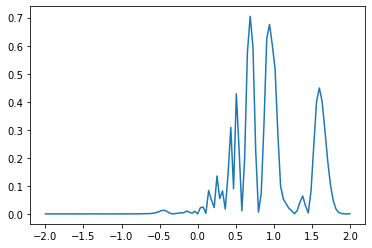

In [3]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm
all_results = []
_amp = 3.5*2*np.pi
_off = 0
_dur = 25
_ramp_coef = 1

def vary_offset(off):
    tlist = np.linspace(0, _dur, int(_dur*5))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": _dur,
        "amplitude": _amp
    }

offs_to_test = np.linspace(-2, 2, 111)
offset_varying_results = parfor(vary_offset, offs_to_test)

_fids_off_sweep = []
_offs_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])
    _offs_off_sweep.append(result["offset"])

plt.plot(_offs_off_sweep, _fids_off_sweep)
plt.show()
# best_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
# offs_to_test = np.linspace(best_offset-0.01, best_offset+0.01, 50)
# offset_varying_results = parfor(vary_offset, offs_to_test)

In [4]:
offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
duration = offset_varying_results[np.argmax(_fids_off_sweep)]["duration"]
amplitude = offset_varying_results[np.argmax(_fids_off_sweep)]["amplitude"]
offset_varying_results[np.argmax(_fids_off_sweep)]

{'fidelity': 0.7049838289859117,
 'offset': 0.6909090909090909,
 'frequency': 7.62628990243179,
 'duration': 25,
 'amplitude': 21.991148575128552}

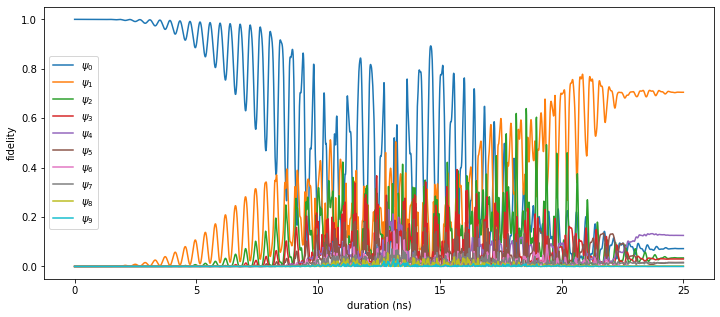

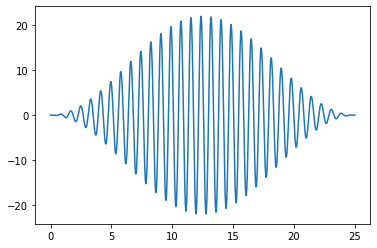

In [5]:
import utils.graph as g

tlist = np.linspace(0, duration, int(duration*100))
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
plt.show()
plt.plot(tlist, pulse_gen.get_pulse(tlist))

## Next, start optimization with given params

In [6]:
def cost_standard(parameters, constants):
    offset = parameters[0]
    amplitude = parameters[1]
    duration = constants[0]
    tlist = np.linspace(0, duration, int(duration*5))
    pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    return (1-fidelity)

offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
duration = offset_varying_results[np.argmax(_fids_off_sweep)]["duration"]
amplitude = offset_varying_results[np.argmax(_fids_off_sweep)]["amplitude"]
optimization_result_standard = sp.optimize.minimize(cost_standard, [offset, amplitude], [duration], method="Nelder-Mead", options={"disp":True})

Optimization terminated successfully.
         Current function value: 0.180805
         Iterations: 30
         Function evaluations: 65


In [7]:
optimization_result_standard

 final_simplex: (array([[ 0.71785327, 22.21696502],
       [ 0.71783779, 22.21690049],
       [ 0.71784534, 22.2169685 ]]), array([0.18080522, 0.18080522, 0.18080539]))
           fun: 0.1808052161930781
       message: 'Optimization terminated successfully.'
          nfev: 65
           nit: 30
        status: 0
       success: True
             x: array([ 0.71785327, 22.21696502])

In [8]:
best_standard_fidelity = (1 - optimization_result_standard.fun)
best_standard_duration = duration
best_standard_offset = optimization_result_standard.x[0]
best_standard_amplitude = optimization_result_standard.x[1]

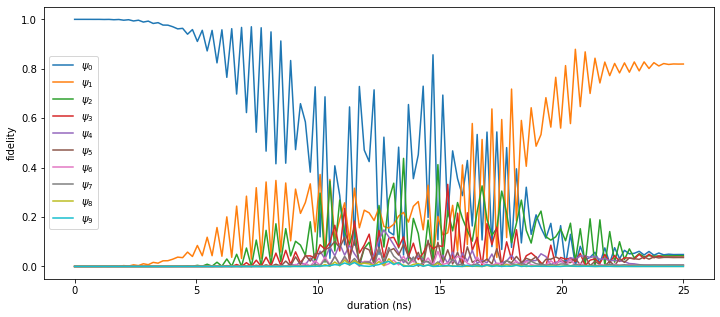

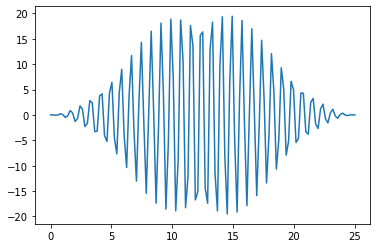

In [9]:
import utils.graph as g

tlist = np.linspace(0, best_standard_duration, int(best_standard_duration*5))
pulse_gen.setup(amplitude=best_standard_amplitude, drive_frequency= system.first_energy_spacing/3 - best_standard_offset, ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
pulse_gen.setup(amplitude=best_standard_amplitude, drive_frequency= system.first_energy_spacing/3 - best_standard_offset, ramp_coef=_ramp_coef, tlist=tlist)
plt.show()
plt.plot(tlist, pulse_gen.get_pulse(tlist))

# Add DRAG correction
Optimize drag coefficient to try to increase fidelity

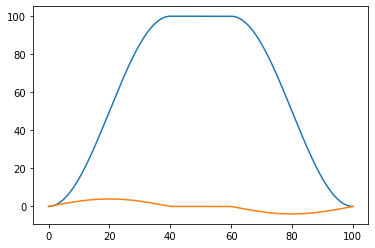

In [10]:
tlist = np.linspace(0, 100, int(100*5))
pulse_gen.setup(amplitude=100, drive_frequency= 0, ramp_coef=0.8, tlist=tlist)
tukey_derivative.setup(amplitude=100, drive_frequency= 0, ramp_coef=0.8, tlist=tlist)
plt.plot(tlist, pulse_gen.get_pulse(tlist))
plt.plot(tlist, tukey_derivative.get_pulse(tlist))
# derivative works!

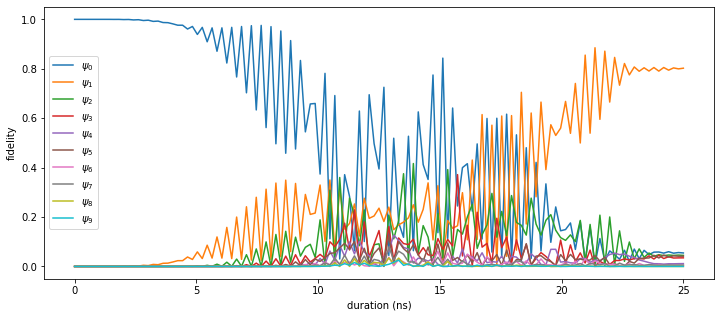

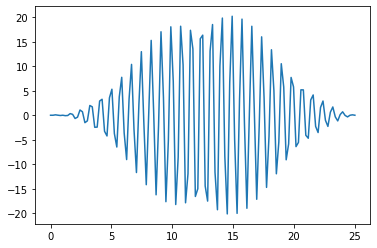

In [11]:
_drag_coef = -0.5

def pulse_with_DRAG(t, args=None):
    return pulse_gen.pulse_func(t) + _drag_coef * tukey_derivative.pulse_func(t)

tlist = np.linspace(0, best_standard_duration, int(best_standard_duration*5))
pulse_gen.setup(amplitude=best_standard_amplitude, drive_frequency= system.first_energy_spacing/3 - best_standard_offset, ramp_coef=_ramp_coef, tlist=tlist)
tukey_derivative.setup(amplitude=best_standard_amplitude, drive_frequency= system.first_energy_spacing/3 - best_standard_offset, ramp_coef=_ramp_coef, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_with_DRAG, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
g.graph_solution(solution, system)
plt.show()
plt.plot(tlist, np.vectorize(pulse_with_DRAG)(tlist))

## Sweep DRAG coefs

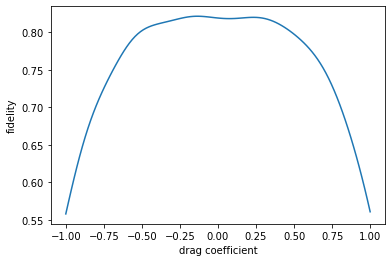

In [12]:
offset = best_standard_offset
duration = best_standard_duration
amplitude = best_standard_amplitude

def vary_drag(drag):
    def _pulse_with_DRAG(t, args=None):
        return pulse_gen.pulse_func(t) + drag * tukey_derivative.pulse_func(t)
    # tlist = np.linspace(0, duration, int(duration*5))
    # pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=_pulse_with_DRAG, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": offset,
        "frequency":  system.first_energy_spacing/3 - offset,
        "duration": duration,
        "amplitude": amplitude,
        "drag": drag
    }

drags_to_test = np.linspace(-1, 1, 111)
drag_varying_results = parfor(vary_drag, drags_to_test)

_fids_drag_sweep = []
_drags_drag_sweep = []
for result in drag_varying_results:
    _fids_drag_sweep.append(result["fidelity"])
    _drags_drag_sweep.append(result["drag"])

plt.plot(_drags_drag_sweep, _fids_drag_sweep)
plt.xlabel("drag coefficient")
plt.ylabel("fidelity")
plt.show()
best_drag_so_far = _drags_drag_sweep[np.argmax(_fids_drag_sweep)]

In [13]:
best_drag_so_far

-0.12727272727272732

In [14]:
def cost_drag(parameters, constants):
    global _drag_coef
    _drag_coef = parameters[0]
    offset = constants[0]
    duration = constants[1]
    amplitude = constants[2]
    tlist = np.linspace(0, duration, int(duration*5))
    pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    tukey_derivative.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=_ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_with_DRAG, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    # debug stuff was here
    # g.graph_solution(solution, system)
    # plt.show()
    # print(offset ,duration, amplitude, _drag_coef)
    # input()
    print(fidelity)
    return (1-fidelity)

constants = [best_standard_offset, best_standard_duration, best_standard_amplitude]
optimization_result_drag = sp.optimize.minimize(cost_drag, [best_drag_so_far], constants, method="Nelder-Mead", options={"disp":True})

0.8215637510451184
0.8215789526362844
0.8215739132535403
0.8215778617891492
0.8215747186513438
0.8215783947113551
0.8215766228873267
0.8215795072680414
0.8215783955237641
0.8215792488514642
0.8215785082751558
0.8215793956275772
0.8215777692929009
0.8215794731323902
Optimization terminated successfully.
         Current function value: 0.178420
         Iterations: 7
         Function evaluations: 14


In [15]:
_drag_coef = optimization_result_drag.x[0]
optimization_result_drag

 final_simplex: (array([[-0.13443182],
       [-0.13433239]]), array([0.17842049, 0.17842053]))
           fun: 0.1784204927319586
       message: 'Optimization terminated successfully.'
          nfev: 14
           nit: 7
        status: 0
       success: True
             x: array([-0.13443182])

In [16]:
best_drag_fidelity = 1 - optimization_result_drag.fun
print("best_drag_fidelity ", best_drag_fidelity)
print("best_standard_fidelity ", best_standard_fidelity)
print("improvement due to drag", best_drag_fidelity - best_standard_fidelity)

best_drag_fidelity  0.8215795072680414
best_standard_fidelity  0.8191947838069219
improvement due to drag 0.002384723461119509


# Start GRAPE with best DRAG curve

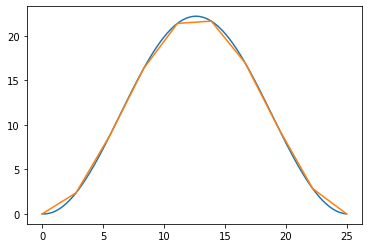

In [17]:

tlist = np.linspace(0, duration, 10000)
# system.first_energy_spacing/3 - offset
pulse_gen.setup(amplitude, drive_frequency= 0 , ramp_coef=_ramp_coef, tlist=tlist)
tukey_derivative.setup(amplitude, drive_frequency= 0 , ramp_coef=_ramp_coef, tlist=tlist)
best_drag_pulse = pulse_gen.get_pulse(tlist) + _drag_coef * tukey_derivative.get_pulse(tlist)
plt.plot(tlist, best_drag_pulse)
bin_size = 2.5
smoothing_time = 5
binned_tlist = np.linspace(0, tlist[-1], int(tlist[-1]/bin_size))
binned_best_drag_pulse = pulse_gen.get_pulse(binned_tlist) + _drag_coef * tukey_derivative.get_pulse(binned_tlist)
plt.plot(binned_tlist, binned_best_drag_pulse)

In [18]:
duration

25

In [19]:
grape.setup(system, binned_best_drag_pulse, offset, duration, bin_size, smoothing_time)

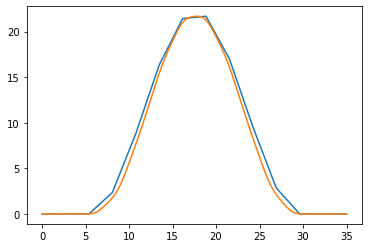

In [20]:
plt.plot(grape.config.time, grape.config.original_pulse)
plt.plot(grape.config.smoothed_time, grape.config.original_pulse_smoothed)

### **Not the right length pulse anymore !**
This is probably a problem with how grape splits up the time into bins where we have a rounding error for how many bins the pulse should be.

In [21]:
solution = grape.single_run()

best_drag_fidelity 0.8215795072680414
starting grape fidelity  0.013897410464664242
difference  -0.8076820968033772
Fidelity = 0.013897, Offset = 0.717853


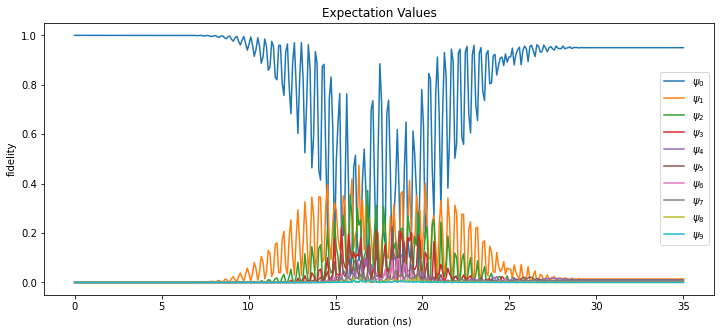

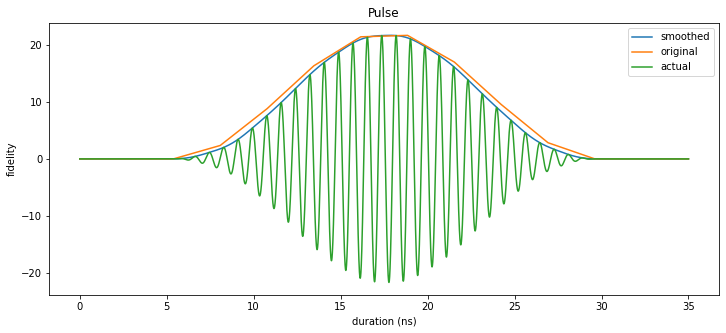

In [22]:
print("best_drag_fidelity", best_drag_fidelity)
expectation_values = expect.get_all_expectation_values(grape.config.last_solution.states, system.basis_states)
print("starting grape fidelity ", expectation_values[1][-1])
print("difference ", expectation_values[1][-1] - best_drag_fidelity)

grape.graph_last_solution()

In [24]:
# THIS TAKES TOO LONG AND WE LOSE PRECISION OF WAVE PULSE USING GRAPE

final_result = grape.optimize(method="L-BFGS-B")

7 : 0.014422
8 : 0.014422
9 : 0.014422
10 : 0.014422
11 : 0.014422
12 : 0.014422
13 : 0.014422
14 : 0.014422
15 : 0.014422
16 : 0.014422
17 : 0.014422
18 : 0.014422
19 : 0.014422
20 : 0.014422
21 : 0.014422
22 : 0.014422
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85578D-01    |proj g|=  1.53038D+00


 This problem is unconstrained.


23 : 0.001823
24 : 0.001823
25 : 0.001823
26 : 0.001823
27 : 0.001823
28 : 0.001823
29 : 0.001823
30 : 0.001823
31 : 0.001823
32 : 0.001823
33 : 0.001823
34 : 0.001823
35 : 0.001823
36 : 0.001823
37 : 0.001823
38 : 0.001823
39 : 0.065624
40 : 0.065624
41 : 0.065624
42 : 0.065624
43 : 0.065624
44 : 0.065624
45 : 0.065624
46 : 0.065624
47 : 0.065624
48 : 0.065624
49 : 0.065624
50 : 0.065624
51 : 0.065624
52 : 0.065624
53 : 0.065624
54 : 0.065624
55 : 0.514354
56 : 0.514354
57 : 0.514354
58 : 0.514354
59 : 0.514354
60 : 0.514354
61 : 0.514354
62 : 0.514354
63 : 0.514354
64 : 0.514354
65 : 0.514354
66 : 0.514354
67 : 0.514354
68 : 0.514354
69 : 0.514354
70 : 0.514354

At iterate    1    f=  4.85646D-01    |proj g|=  5.98754D-01
71 : 0.523930
72 : 0.523930
73 : 0.523930
74 : 0.523930
75 : 0.523930
76 : 0.523930
77 : 0.523930
78 : 0.523930
79 : 0.523930
80 : 0.523930
81 : 0.523930
82 : 0.523930
83 : 0.523930
84 : 0.523930
85 : 0.523930
86 : 0.523930
87 : 0.340356
88 : 0.340356
89 : 0.340356


In [25]:
final_result

      fun: 0.19808146867900533
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00240874,  0.00079026,  0.00401416, -0.00242795, -0.01071517,
       -0.01587884,  0.0158905 , -0.00617768, -0.00225234, -0.01463467,
        0.00581954,  0.00429213,  0.00079557,  0.00330126, -0.09158885])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 528
      nit: 13
     njev: 33
   status: 0
  success: True
        x: array([-2.03108360e-02, -3.27651435e-03, -1.32687154e-03,  2.35888302e+00,
        9.26905181e+00,  1.65356500e+01,  2.14387422e+01,  2.27474297e+01,
        1.71959488e+01,  9.56266348e+00,  2.82858360e+00, -3.86867113e-03,
       -4.07068769e-03,  6.59302086e-04,  7.10243881e-01])

Fidelity = 0.801919, Offset = 0.710244


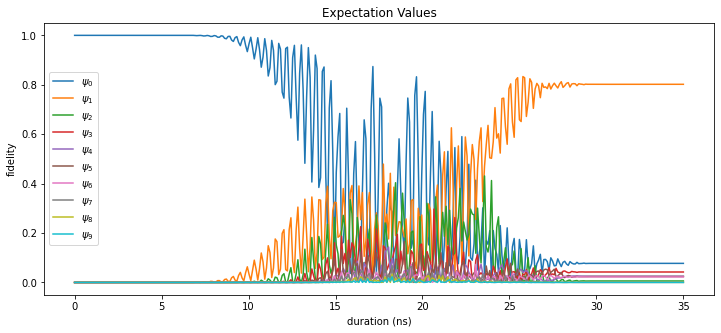

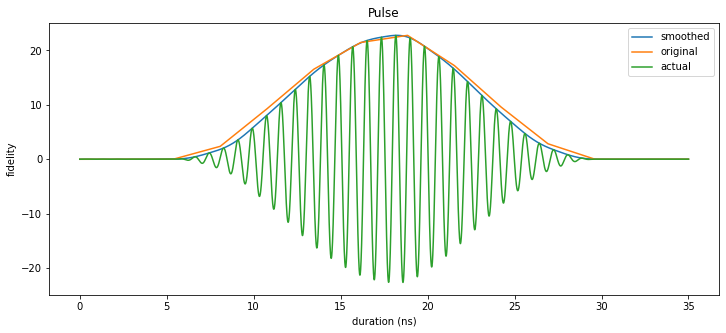

In [26]:
grape.graph_last_solution()